This notebook walks through a practical implementation of the **PointPillars** architecture for 3D object detection using the **KITTI dataset**. The goal is to explore how LiDAR point clouds and labels are prepared, visualized, and eventually used for detection tasks using a TensorFlow-based pipeline.

##  Goals
- Understand the structure and purpose of the PointPillars implementation.
- Explore input data (LiDAR point clouds and annotations).
- Visualize sample scenes and 2D projections of 3D labels.
- Inspect and interpret model hyperparameters.
- Prepare the environment for training and inference workflows.

##  Notebook Structure
1. **Environment Setup & Imports**  
   Load dependencies and configure TensorFlow, plotting, and dataset paths.

2. **Parameter Inspection**  
   View and understand key configuration values (e.g., anchor dimensions, grid sizes, thresholds).

3. **Dataset Exploration**  
   Access KITTI LiDAR data and corresponding labels (point clouds, annotations, calibration files).

4. **Visualization**  
   Render point clouds in 2D bird’s-eye-view and overlay object labels by computing vertices from 3D annotations.

5. **Next Steps (Optional Extensions)**  
   - Modify hyperparameters  
   - Prepare training batches  
   - Run inference  
   - Evaluate predictions

![SamplePointCloudandLabels.png](assets/2025-09-30_00-57.png)

### Installation and Imports

This assignment relies primarily on a modified [TensorFlow implementation](https://github.com/ika-rwth-aachen/PointPillars) of [PointPillars](https://arxiv.org/abs/1812.05784). The `point_pillars` Python package has already been installed and configured within this notebook. In the following step, we will import all required dependencies and set up the workspace, after which we can begin the first part of the exercise.


In [14]:
import sys
import os
os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import cv2
import numpy as np
import tensorflow as tf
from glob import glob 

import matplotlib.pyplot as plt
import math
from beeprint import pp

from point_pillars import createPillars

sys.path.append('object_detection')
from object_detection.config import Parameters
from object_detection.loss import PointPillarNetworkLoss
from object_detection.processors import SimpleDataGenerator
from object_detection.readers import KittiDataReader
from object_detection.inference_utils import generate_bboxes_from_pred, rotational_nms

from object_detection.utils import setUpPlot, plot2DVertices, plot2DLabel, plot2DBox, transform_labels_into_lidar_coordinates
from object_detection.utils import build_pillar_net, build_detection_head

DATA_ROOT = "datasets/kitti"
MODEL_ROOT = "object_detection/model"

## Parameters

Training neural networks involves numerous settings and hyperparameters. To provide a clearer overview, the following command displays the default parameters defined in the [config.py](object_detection/config.py) file of the PointPillars environment.


In [15]:
params = Parameters()
pp(Parameters)

class(Parameters):
  L1: 0,
  L2: 0,
  Xn: 504,
  Xn_f: 504.0,
  Yn: 504,
  Yn_f: 504.0,
  alpha: 0.25,
  anchor_dims: [
    [3.9000000953674316, 1.600000023841858, 1.559999942779541, -1.0, 0.0],
    [3.9000000953674316, 1.600000023841858, 1.559999942779541, -1.0, 1.5707999467849731],
    [0.800000011920929, 0.6000000238418579, 1.7300000190734863, -0.6000000238418579, 0.0],
    [0.800000011920929, 0.6000000238418579, 1.7300000190734863, -0.6000000238418579, 1.5707999467849731],
  ],
  angle_threshold: 0.87,
  angle_weight: 1.0,
  batch_size: 1,
  class_weight: 0.5,
  classes: {
    'Car': 0,
    'Cyclist': 2,
    'Misc': 3,
    'Pedestrian': 1,
    'Person_sitting': 1,
    'Tram': 3,
    'Truck': 3,
    'Van': 3,
  },
  decay_rate: 1e-08,
  downscaling_factor: 2,
  focal_weight: 3.0,
  gamma: 2.0,
  heading_weight: 0.2,
  iters_to_decay: 101040.0,
  learning_rate: 0.0002,
  loc_weight: 2.0,
  max_pillars: 12000,
  max_points_per_pillar: 100,
  min_distance: 3.0,
  nb_channels: 64,
  nb

This configuration includes parameters for constructing the network architecture, controlling the training process, and generating the anchor boxes. The overview provided here is intended as a brief summary; some of these parameters will need to be modified later.


## Dataset

Developing object detection models, particularly with deep learning, requires large datasets. For this purpose, we use the [3D Object Detection Evaluation](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d) dataset, which contains 7,481 manually annotated point clouds. The point clouds are stored in `datasets/kitti/velodyne`, with corresponding labels in `datasets/kitti/label_2`. In this assignment, we will use only 200 labeled point clouds to reduce training time. We begin by briefly exploring the available data.


### Visualize a Sample 3D Point Cloud with Labels

The goal of this task is to visualize the available KITTI dataset input, focusing on 2D bird’s-eye view labels for simplicity. Key points:

* **Visualization Tools**: Use [Matplotlib](https://matplotlib.org/) for plotting.
* **Data Access**: The `KittiDataReader` class provides helper functions:

  * `read_lidar(file_name)` – Load LiDAR point clouds.
  * `read_label(file_name)` – Load object labels.
  * `read_calibration(file_name)` – Load calibration files to align coordinate systems.
* **Coordinate Transformation**:

  * KITTI labels and point clouds are recorded in different coordinate systems.
  * Use the pre-implemented function `transform_labels_into_lidar_coordinates` to convert labels into the LiDAR coordinate system.
* **Plotting Labels**:

  * Visualize labels in the bird’s-eye view.
  * Provided: a list of `label3D` objects.
  * Use the pre-implemented `plot2DLabels` function to plot the rectangular labels by supplying the four vertices.

![bounding_box_computation.png](assets/2025-09-30_01-12.png)

### Instructions for Calculating 2D Label Vertices

1. **Identify the Centroid**: Start from the centroid of the 3D label.
2. **Obtain Dimensions and Orientation**: Retrieve the **length** (l), **width** (w), and **yaw angle** (\theta) of the label.
3. **Compute Corner Offsets**: Calculate the half-length (v_l) and half-width (v_w) to determine offsets from the centroid.
4. **Determine Corner Positions**: Using the offsets and ya
w angle, compute the coordinates of the four corners:

   * **FL** (Front Left)
   * **FR** (Front Right)
   * **RL** (Rear Left)
   * **RR** (Rear Right)
5. **Set Z-Coordinate**: For all corners, use the same z-coordinate as the centroid, since the visualization is in 2D (bird’s-eye view).
6. **Format Vertices**: Store each corner as a **list of three values** `[x, y, z]`.

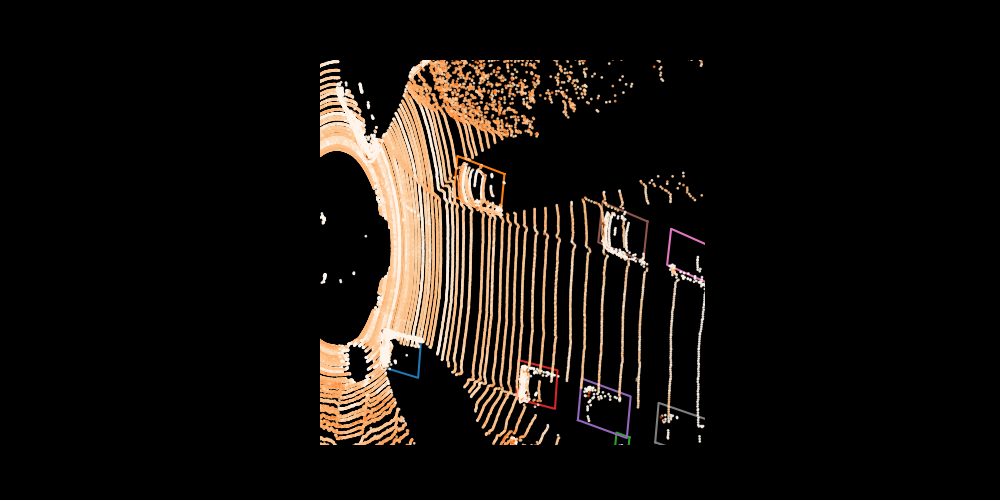

In [16]:
%matplotlib widget

# sample index for plotting
idx = 10

# read data
data_reader = KittiDataReader()
lidar = data_reader.read_lidar(os.path.join(DATA_ROOT, "velodyne", str(idx).zfill(6)+".bin"))
label = data_reader.read_label(os.path.join(DATA_ROOT, "label_2", str(idx).zfill(6)+".txt"))
R, t = data_reader.read_calibration(os.path.join(DATA_ROOT, "calib", str(idx).zfill(6)+".txt"))
label_transformed = transform_labels_into_lidar_coordinates(label, R, t)

# plot settings
ax = setUpPlot()

# plot sample pointcloud
ax.scatter(lidar[:,0], lidar[:,1], lidar[:,2], c=lidar[:,3], cmap='Oranges', s=1)

# plot labels
for l in label_transformed:
    
    x = l.centroid[0] 
    y = l.centroid[1]
    z = l.centroid[2]
    length = l.dimension[0]
    width = l.dimension[1]
    height = l.dimension[2]
    yaw = l.yaw
    
    v_l_x = np.cos(yaw) * length / 2
    v_l_y = np.sin(yaw) * length / 2
    
    v_w_x = np.sin(yaw) * width / 2
    v_w_y = np.cos(yaw) * width / 2
    
    FL = [x + v_l_x + v_w_x, y - v_l_y + v_w_y, z]
    FR = [x + v_l_x - v_w_x, y - v_l_y - v_w_y, z]
    RL = [x - v_l_x + v_w_x, y + v_l_y + v_w_y, z]
    RR = [x - v_l_x - v_w_x, y + v_l_y - v_w_y, z]

    
    plot2DVertices(ax, FL, FR, RR, RL)

### Training / Validation / Test Split

Neural network training requires several preprocessing steps, including data augmentation, normalization, and the organization of the dataset into **training**, **validation**, and **test** subsets. A common practice in the literature is to adopt a **70/20/10 split**, which is applied here to the 100 samples from the KITTI dataset.

The three datasets are created using the `SimpleDataGenerator` class with the following constructor:

```python
def __init__(self, data_reader: DataReader, batch_size: int, lidar_files: List[str], label_files: List[str] = None, calibration_files: List[str] = None):
```

**Procedure:**

* Determine the size of each subset as integers, ensuring that the sum equals the total number of samples.
* Since the KITTI dataset is unsorted, the split can be performed without shuffling.
* Generate separate file lists for LiDAR data, labels, and calibration files corresponding to each subset: training, validation, and test.
* Instantiate each dataset using the `SimpleDataGenerator` class.
* Apply the `batch_size` specified in the `params` object for all datasets.


In [17]:
data_reader = KittiDataReader()

lidar_files = sorted(glob(os.path.join(DATA_ROOT, "velodyne", "*.bin")))
label_files = sorted(glob(os.path.join(DATA_ROOT, "label_2", "*.txt")))
calibration_files = sorted(glob(os.path.join(DATA_ROOT, "calib", "*.txt")))

m = len(label_files)

### START TASK 2 CODE

## define lengths of each dataset
training_len = m - int(0.2*m) - int(0.1*m)
validation_len = int(0.2*m)
test_len = int(0.1*m)

lidar_training = lidar_files[:training_len]
label_training = label_files[:training_len]
calib_training = calibration_files[:training_len]

lidar_validation = lidar_files[training_len:training_len+validation_len]
label_validation = label_files[training_len:training_len+validation_len]
calib_validation = calibration_files[training_len:training_len+validation_len]

lidar_test = lidar_files[-test_len:]
label_test = label_files[-test_len:]
calib_test = calibration_files[-test_len:]

# create the datasets by using the `SimpleDataGenerator`
training_gen = SimpleDataGenerator(data_reader, params.batch_size, lidar_training, label_training, calib_training)
validation_gen = SimpleDataGenerator(data_reader, params.batch_size, lidar_validation, label_validation, calib_validation)
test_gen = SimpleDataGenerator(data_reader, params.batch_size, lidar_test, label_test, calib_test)

### END TASK 2 CODE

print("Defined training files: ", training_len, " training batches:", len(training_gen))
print("Defined validation files: ", validation_len, " validation batches:", len(validation_gen))
print("Defined test files: ", test_len, " test batches:", len(test_gen))

Defined training files:  70  training batches: 70
Defined validation files:  20  validation batches: 20
Defined test files:  10  test batches: 10


## Network Architecture

In recent years, deep learning techniques have achieved significant advances across many domains. A state-of-the-art neural network architecture for 3D object detection in computer vision is [PointPillars](https://arxiv.org/abs/1812.05784).

The architecture decomposes the task into three main components:

* **Pillar Feature Network**: Converts the point cloud into a structured, grid-based feature representation.
* **2D CNN Backbone**: Processes the feature map to extract high-level spatial features.
* **Detection Head**: Predicts the parameters of 3D bounding boxes for objects.

![Pointpillars.png](assets/2025-09-30_01-19.png)

A detailed explanation of the architecture is beyond the scope of this assignment. The figure above provides an overview of the network structure, which will be implemented in [TensorFlow](https://www.tensorflow.org/) in the following steps. For a complete description, refer to the original [PointPillars paper](https://arxiv.org/abs/1812.05784).


### Constructing the Neural Network Model

Due to the complexity of the complete PointPillars architecture, this task focuses on implementing the **Convolutional Neural Network (CNN) backbone**. The backbone follows a U-Net style structure and is composed of three main blocks, as illustrated in the figure above. Each block contains multiple convolutional layers with batch normalization, operating at different stride levels in a top-down hierarchy:

* **Block 1 (4, C)**: 4 convolutional layers with (C = 64) output filters.
* **Block 2 (6, 2C)**: 6 convolutional layers with (2C = 128) output filters.
* **Block 3 (6, 2C)**: 6 convolutional layers with (2C = 128) output filters.

All convolutional layers use a fixed **3×3 filter**, **stride S**, **‘same’ padding**, and **ReLU activation**.

The task is to complete the implementation of **Block 2** in the `build_cnn_backbone` function, following the same structure as Blocks 1 and 3.

**Instructions:**

* The structure of Block 2 is analogous to Blocks 1 and 3.
* Use [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to define convolutional layers.
* Apply batch normalization using [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization).


In [18]:
def build_cnn_backbone(pillars, params):

    nb_channels = int(params.nb_channels)

    # 2d cnn backbone

    # Block1(4, C)
    x = pillars
    for n in range(4):
        S = (2, 2) if n == 0 else (1, 1)
        x = tf.keras.layers.Conv2D(nb_channels, (3, 3), strides=S, padding="same", activation="relu",
                                   name="cnn/block1/conv2d%i" % n)(x)
        x = tf.keras.layers.BatchNormalization(name="cnn/block1/bn%i" % n, fused=True)(x)
    x1 = x

    # Block2(6, 2C)
    ### START TASK 3 CODE
    for n in range(6):
        S = (2, 2) if n == 0 else (1, 1)
        x = tf.keras.layers.Conv2D(2 * nb_channels, (3, 3), strides=S, padding="same", activation="relu",
                                   name="cnn/block2/conv2d%i" % n)(x)
        x = tf.keras.layers.BatchNormalization(name="cnn/block2/bn%i" % n, fused=True)(x)
    x2 = x
    


    ### END TASK 3 CODE
    
    # Block3(6, 2C)
    for n in range(6):
        S = (2, 2) if n == 0 else (1, 1)
        x = tf.keras.layers.Conv2D(2 * nb_channels, (3, 3), strides=S, padding="same", activation="relu",
                                   name="cnn/block3/conv2d%i" % n)(x)
        x = tf.keras.layers.BatchNormalization(name="cnn/block3/bn%i" % n, fused=True)(x)
    x3 = x

    # Up1 (S, S, 2C)
    up1 = tf.keras.layers.Conv2DTranspose(2 * nb_channels, (3, 3), strides=(1, 1), padding="same", activation="relu",
                                          name="cnn/up1/conv2dt")(x1)
    up1 = tf.keras.layers.BatchNormalization(name="cnn/up1/bn", fused=True)(up1)

    # Up2 (2S, S, 2C)
    up2 = tf.keras.layers.Conv2DTranspose(2 * nb_channels, (3, 3), strides=(2, 2), padding="same", activation="relu",
                                          name="cnn/up2/conv2dt")(x2)
    up2 = tf.keras.layers.BatchNormalization(name="cnn/up2/bn", fused=True)(up2)

    # Up3 (4S, S, 2C)
    up3 = tf.keras.layers.Conv2DTranspose(2 * nb_channels, (3, 3), strides=(4, 4), padding="same", activation="relu",
                                          name="cnn/up3/conv2dt")(x3)
    up3 = tf.keras.layers.BatchNormalization(name="cnn/up3/bn", fused=True)(up3)

    # Concat
    concat = tf.keras.layers.Concatenate(name="cnn/concatenate")([up1, up2, up3])

    return concat

### Test implemented function `build_cnn_backbone`

In [19]:
# create inputs
input_pillars = tf.keras.layers.Input((params.max_pillars, params.max_points_per_pillar, params.nb_features), batch_size=params.batch_size, name="pillars/input")
input_indices = tf.keras.layers.Input((params.max_pillars, 3), batch_size=params.batch_size, name="pillars/indices", dtype=tf.int32)
    
# create pillar_net, consisting of the three subparts
pillars = build_pillar_net(input_pillars, input_indices, params)

cnn = build_cnn_backbone(pillars, params)

pillar_net = build_detection_head(cnn, input_pillars, input_indices, params)

print(pillar_net.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pillars/input (InputLayer)     [(1, 12000, 100, 9)  0           []                               
                                ]                                                                 
                                                                                                  
 pillars/conv2d (Conv2D)        (1, 12000, 100, 64)  576         ['pillars/input[0][0]']          
                                                                                                  
 pillars/batchnorm (BatchNormal  (1, 12000, 100, 64)  256        ['pillars/conv2d[0][0]']         
 ization)                                                                                         
                                                                                            

### Callbacks, Loss and Optimizer
We now defined some callback functions to save current training status and monitor the overall training progress.

In [20]:
epoch_to_decay = int(np.round(params.iters_to_decay / params.batch_size * int(np.ceil(float(len(label_files)) / params.batch_size))))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=MODEL_ROOT, profile_batch=0),
    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_ROOT, "model.h5"),
                                       monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr * 0.8 if ((epoch % epoch_to_decay == 0) and (epoch != 0)) else lr, verbose=True),
    tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
]

Now we set `Adam` as optimizer and define the losses. Have a look into `PointPillarNetworkLoss` in [loss.py](object_detection/loss.py) for a detailed overview of the different loss parts, which are a localization loss, a dimension loss, an angle and heading loss and finally a classification loss. 

In a last step the model is compiled using the [`compile()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) function.

In [21]:
# setup optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=params.learning_rate, decay=params.decay_rate)
loss = PointPillarNetworkLoss(params)

# compile tensorflow model
pillar_net.compile(optimizer, loss=loss.losses())

## Training

After preparing the datasets and constructing and compiling the model, the first 3D object detection training using the PointPillars architecture can be performed.

### Task 4: Model Training

Training is conducted using the TensorFlow-Keras `fit()` function, which requires the training and validation datasets, callbacks, and other relevant training parameters. The network should be trained on the training and validation subsets for **one epoch**.

**Notes:**

* Training for one epoch takes approximately 2–3 minutes. This is sufficient for the purpose of this assignment, as a fully trained network is provided for subsequent steps.

**Procedure:**

* Apply the TensorFlow [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function.
* Use the previously created datasets: `training_gen` and `validation_gen`.
* Include the `callbacks` list.
* Set `steps_per_epoch` equal to the length of `training_gen`.
* Enable multiprocessing with 6 workers.
* Train for one epoch.


In [22]:
history = pillar_net.fit(training_gen,
                       validation_data = validation_gen,
                       steps_per_epoch=len(training_gen),batch_size=4,
                       callbacks=callbacks,
                       use_multiprocessing=True,
                       epochs=1,
                       workers=6)


print(history.history)


Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
70/70 [==============================] - 77s 1s/step - loss: 3.8305 - occupancy/conv2d_loss: 2.2559 - loc/reshape_loss: 0.0276 - size/reshape_loss: 0.0280 - angle/conv2d_loss: 0.8505 - heading/conv2d_loss: 0.1162 - clf/reshape_loss: 0.5523 - val_loss: 1.3313 - val_occupancy/conv2d_loss: 0.4420 - val_loc/reshape_loss: 0.0371 - val_size/reshape_loss: 0.0382 - val_angle/conv2d_loss: 0.0568 - val_heading/conv2d_loss: 0.1240 - val_clf/reshape_loss: 0.6332 - lr: 2.0000e-04
{'loss': [3.8305368423461914], 'occupancy/conv2d_loss': [2.2559173107147217], 'loc/reshape_loss': [0.027631936594843864], 'size/reshape_loss': [0.027964580804109573], 'angle/conv2d_loss': [0.8505144119262695], 'heading/conv2d_loss': [0.11617514491081238], 'clf/reshape_loss': [0.5523333549499512], 'val_loss': [1.3313398361206055], 'val_occupancy/conv2d_loss': [0.44195085763931274], 'val_loc/reshape_loss': [0.0371418334543705], 'val_size/reshape

In [24]:
history = pillar_net.fit(training_gen,
                       validation_data = validation_gen,
                       steps_per_epoch=len(training_gen),batch_size=4,
                       callbacks=callbacks,
                       use_multiprocessing=True,
                       epochs=1,
                       workers=6)


print(history.history)


Epoch 1: LearningRateScheduler setting learning rate to 0.00019999999494757503.
70/70 [==============================] - 77s 1s/step - loss: 2.2238 - occupancy/conv2d_loss: 0.9983 - loc/reshape_loss: 0.0240 - size/reshape_loss: 0.0223 - angle/conv2d_loss: 0.8611 - heading/conv2d_loss: 0.0512 - clf/reshape_loss: 0.2670 - val_loss: 1.1843 - val_occupancy/conv2d_loss: 0.4490 - val_loc/reshape_loss: 0.0333 - val_size/reshape_loss: 0.0383 - val_angle/conv2d_loss: 0.0701 - val_heading/conv2d_loss: 0.1014 - val_clf/reshape_loss: 0.4922 - lr: 2.0000e-04
{'loss': [2.223769426345825], 'occupancy/conv2d_loss': [0.998259425163269], 'loc/reshape_loss': [0.023981422185897827], 'size/reshape_loss': [0.022256020456552505], 'angle/conv2d_loss': [0.8610522150993347], 'heading/conv2d_loss': [0.05118466541171074], 'clf/reshape_loss': [0.2670353353023529], 'val_loss': [1.1843031644821167], 'val_occupancy/conv2d_loss': [0.4490112364292145], 'val_loc/reshape_loss': [0.03332723304629326], 'val_size/reshape_l

dict_keys(['loss', 'occupancy/conv2d_loss', 'loc/reshape_loss', 'size/reshape_loss', 'angle/conv2d_loss', 'heading/conv2d_loss', 'clf/reshape_loss', 'val_loss', 'val_occupancy/conv2d_loss', 'val_loc/reshape_loss', 'val_size/reshape_loss', 'val_angle/conv2d_loss', 'val_heading/conv2d_loss', 'val_clf/reshape_loss', 'lr'])


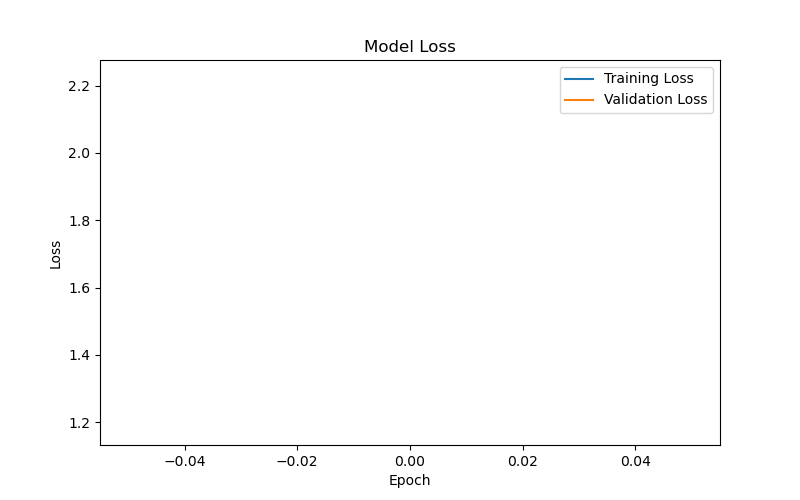

In [25]:
import matplotlib.pyplot as plt

# Print keys to see what metrics are available
print(history.history.keys())

# Example: Plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Example: Plot a metric (e.g., accuracy) if it exists
if 'accuracy' in history.history or 'val_accuracy' in history.history:
    plt.figure(figsize=(8,5))
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


## Inference 

In [23]:
piller_net.fit?

Object `piller_net.fit` not found.


### Load Pretrained Model
Since useful training on a large variable trainingset often takes lots of hours or sometimes days we provided such a full-trained model in `object_detection/model/model_pretrained.h5`. The following cell loads the model, which now shows much better performance in the next inference tasks, than our self-trained model.

In [26]:
pillar_net.load_weights(os.path.join(MODEL_ROOT, "pretrained_model.h5"))

### Prediction
We can now perform __inference__ on that pretrained model by loading a sample from the dataset and use the model's `predict` function.

In [27]:
occupancy, position, size, angle, heading, classification = pillar_net.predict(test_gen, batch_size=params.batch_size)

print("Occupancy shape: ", occupancy.shape)
print("Position shape: ", position.shape)
print("Size shape: ", size.shape)
print("Angle shape: ", angle.shape)
print("Heading shape: ", heading.shape)
print("Classification shape: ", classification.shape)

10/10 [==============================] - 3s 235ms/step
Occupancy shape:  (10, 252, 252, 4)
Position shape:  (10, 252, 252, 4, 3)
Size shape:  (10, 252, 252, 4, 3)
Angle shape:  (10, 252, 252, 4)
Heading shape:  (10, 252, 252, 4)
Classification shape:  (10, 252, 252, 4, 4)


The output are tensors where for each sample (8), every grid cell (252 x 252), and every anchor (4) a given target is computed. As already described in the loss setup, different tensors are created for the different tasks. While occupancy, angle and heading prediction are single values, the anchor's output for the position and size are vectors.

## Filtering and Non-Maximum Suppression

In the subsequent processing step, the computed targets for each anchor are analyzed to generate classified bounding boxes. Only predictions exceeding a specified confidence score threshold (`score_threshold`) are retained for further consideration.

The remaining bounding boxes are then refined using Non-Maximum Suppression (NMS). The `iou_threshold` defines the overlap threshold applied during NMS, corresponding to the second threshold discussed in the lecture slides.

### Task 5: Determination of Appropriate Thresholds

The final task of this assignment involves selecting suitable thresholds for postprocessing. In practical applications, evaluation metrics (as presented in the lecture) are typically employed to determine optimal thresholds. For this assignment, threshold selection is performed manually. Appropriate values for the following parameters should be identified based on predictions from the eight test samples:

* `score_threshold`
* `iou_threshold`

**Instructions :**

* Utilize the provided plotting script to visualize predictions.
* Ground truth bounding boxes are indicated in green.
* PointPillars detections after filtering and Non-Maximum Suppression are displayed in blue.

In [28]:
# Hint: a small threshold results in too many, a high threshold in too few detections
score_threshold = 0.5
iou_threshold = 0.5

set_boxes, confidences = [], []
loop_range = occupancy.shape[0] if len(occupancy.shape) == 4 else 1

for i in range(loop_range):
    set_boxes.append(generate_bboxes_from_pred(occupancy[i], position[i], size[i], angle[i], heading[i], classification[i], params.anchor_dims, occ_threshold=score_threshold))
    confidences.append([float(boxes.conf) for boxes in set_boxes[-1]])

nms_boxes = rotational_nms(set_boxes, confidences, score_threshold=score_threshold, iou_threshold=iou_threshold)

### Plot Detections

GT | Cls: Car, x: 19.452250, y: -0.296232, l: 3.690000, w: 1.650000, yaw: -3.140796
GT | Cls: Car, x: 13.301275, y: -4.632810, l: 3.880000, w: 1.720000, yaw: -2.340796
GT | Cls: Car, x: 24.173037, y: -4.570873, l: 3.460000, w: 1.490000, yaw: -2.360796
GT | Cls: Car, x: 30.819853, y: -4.180834, l: 3.650000, w: 1.610000, yaw: -2.330796
GT | Cls: Car, x: 13.989166, y: 7.082955, l: 4.100000, w: 1.650000, yaw: 0.009204
GT | Cls: Car, x: 31.957432, y: 6.008197, l: 3.770000, w: 1.600000, yaw: 0.069204
GT | Cls: Car, x: 48.197449, y: 4.720428, l: 3.970000, w: 1.700000, yaw: 0.099204
GT | Cls: Car, x: 24.024910, y: 10.508664, l: 4.630000, w: 1.650000, yaw: 0.039204
GT | Cls: Car, x: 30.174873, y: 10.564980, l: 3.930000, w: 1.590000, yaw: 0.019204
GT | Cls: Car, x: 68.456871, y: 1.962807, l: 4.590000, w: 1.840000, yaw: 0.169204
GT | Cls: Car, x: 40.578186, y: 10.013245, l: 4.190000, w: 1.620000, yaw: 0.119204
GT | Cls: Car, x: 53.315235, y: 7.829093, l: 4.530000, w: 1.670000, yaw: 0.289204
GT | 

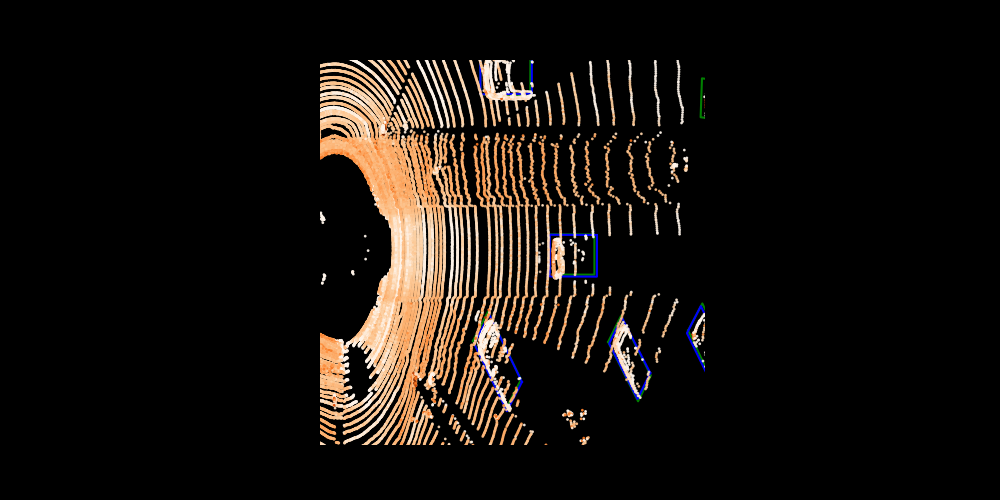

In [30]:
%matplotlib widget

# sample index for plotting
idx = 5

# read data
data_reader = KittiDataReader()
lidar = data_reader.read_lidar(lidar_test[idx])
label = data_reader.read_label(label_test[idx])
R, t = data_reader.read_calibration(calib_test[idx])
label_transformed = transform_labels_into_lidar_coordinates(label, R, t)

# plot settings
ax = setUpPlot()

# plot sample pointcloud
ax.scatter(lidar[:,0], lidar[:,1], lidar[:,2], c=lidar[:,3], cmap='Oranges', s=1)

# plot labels
for l in label_transformed:
    print(l)
    plot2DLabel(ax, l)
    
# plot detections
for d in nms_boxes[idx]:
    print(d)
    plot2DBox(ax, d)


## References

In [31]:
@article{LAN2019,
      title={PointPillars: Fast Encoders for Object Detection from Point Clouds}, 
      author={Alex H. Lang and Sourabh Vora and Holger Caesar and Lubing Zhou and Jiong Yang and Oscar Beijbom},
      year={2019}
}

SyntaxError: invalid syntax (110669428.py, line 1)

In [ ]:
@misc{IKA2022,
  author = {Institute for Automotive Engineering, RWTH Aachen University},
  title = {PointPillars Tensorflow},
  url = {https://github.com/ika-rwth-aachen/PointPillars},
  year = {2022}
}

In [ ]:
@misc{TYA2021,
  author = {tyagi-iiitv},
  title = {PointPillars Tensorflow},
  url = {https://github.com/tyagi-iiitv/PointPillars},
  year = {2021}
}

In [ ]:
@article{GEIG2021,
  author = {Andreas Geiger and Philip Lenz and Raquel Urtasun},
  title = {Are we ready for Autonomous Driving? The KITTI Vision Benchmark Suite},
  booktitle = {Conference on Computer Vision and Pattern Recognition (CVPR)},
  year = {2012}
} 

SyntaxError: invalid syntax (1965316090.py, line 1)